In [2]:
# imports
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, RFECV
from sklearn.calibration import CalibratedClassifierCV


In [3]:
colors = ['#7A00A6',    #purple
        '#0B1EE3',      #darkblue  
        '#00C6E0',      #highlight blue
        '#127139',      #dark green
        '#00E05D'       #highlight green
        ]

#### **Part 1:** EDA

Get baseline values and most important features for ML

In [34]:
# Load data
data = pd.read_csv('data_standardized2.csv')
data = data.drop(["Unnamed: 0"],axis=1)

X = data.copy().drop(columns=['diabetes'])
y = data.copy()['diabetes']

# split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=data['diabetes'],random_state=1)

# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (136789, 19) (136789,)
Test (67375, 19) (67375,)


no     200309
yes      3855
Name: diabetes, dtype: int64


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


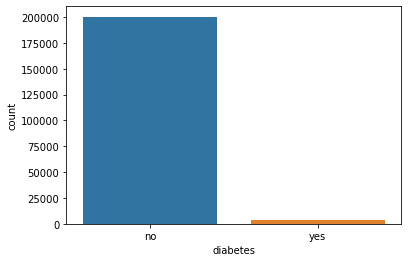

In [24]:
ax = sns.countplot(y,label="Count")
print(data.diabetes.value_counts())

no     200309
yes      3855
Name: diabetes, dtype: int64
              precision    recall  f1-score   support

          no       0.98      1.00      0.99     66103
         yes       0.12      0.00      0.00      1272

    accuracy                           0.98     67375
   macro avg       0.55      0.50      0.50     67375
weighted avg       0.96      0.98      0.97     67375

0.8421941953176372


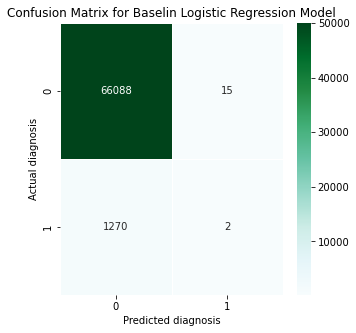

In [35]:
# Baseline Logistic Regression
clf_0 = LogisticRegression().fit(X_train, y_train)
 
# Predict on training set
pred_y_0 = clf_0.predict(X_test)
print(data.diabetes.value_counts())
print(classification_report(y_test, pred_y_0))

prob_y_0 = clf_0.predict_proba(X_test)
prob_y_0 = [p[1] for p in prob_y_0]
print(roc_auc_score(y_test, prob_y_0))

# Create a confusion matrix
prediction = clf_0.predict(X_test)
cm = confusion_matrix(y_test, prediction)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Baseline Logistic Regression Model')
plt.show()

In [12]:
X.corr().style.background_gradient(cmap="Blues")

,sex_male,smoker_former smoker,smoker_never smoker,smoker_no info,drinker_former drinker,drinker_never drinker,drinker_no info,fam_hist_no family history of diabetes,age,height,weight,bmi,sbp,dbp,chol,alt,ast,bun,ccr
sex_male,1.000000,0.099165,-0.004801,-0.133024,0.167638,0.048418,-0.133024,0.049049,0.020035,0.693385,0.603503,0.314914,0.264183,0.254935,0.026235,0.279652,0.109014,0.235568,0.678488
smoker_former smoker,0.099165,1.000000,-0.058125,-0.175888,0.215098,0.075930,-0.175888,-0.015599,-0.017640,0.070723,0.065404,0.036455,0.021412,0.023787,0.003092,0.037767,0.017056,0.017481,0.063804
smoker_never smoker,-0.004801,-0.058125,1.000000,-0.832437,0.181397,0.793490,-0.832437,-0.124226,-0.067782,-0.027415,-0.032819,-0.023174,-0.008076,-0.001688,-0.020032,-0.005572,0.019214,-0.032847,-0.011913
smoker_no info,-0.133024,-0.175888,-0.832437,1.000000,-0.335263,-0.879882,1.000000,0.132543,0.033102,-0.064846,-0.058145,-0.032154,-0.020040,-0.037108,-0.005581,-0.036039,-0.032209,0.001586,-0.072094
drinker_former drinker,0.167638,0.215098,0.181397,-0.335263,1.000000,-0.117108,-0.335263,-0.056495,-0.022047,0.117757,0.113932,0.067986,0.033343,0.040428,0.011099,0.050143,0.022460,0.036956,0.115696
drinker_never drinker,0.048418,0.075930,0.793490,-0.879882,-0.117108,1.000000,-0.879882,-0.111107,-0.032275,0.006035,-0.001408,-0.005271,-0.000535,0.013163,-0.003938,0.011070,0.020029,-0.023651,0.014387
drinker_no info,-0.133024,-0.175888,-0.832437,1.000000,-0.335263,-0.879882,1.000000,0.132543,0.033102,-0.064846,-0.058145,-0.032154,-0.020040,-0.037108,-0.005581,-0.036039,-0.032209,0.001586,-0.072094
fam_hist_no family history of diabetes,0.049049,-0.015599,-0.124226,0.132543,-0.056495,-0.111107,0.132543,1.000000,0.006410,0.025226,0.008880,-0.005590,0.021911,0.008906,-0.013619,-0.001265,-0.000502,0.015682,0.036978
age,0.020035,-0.017640,-0.067782,0.033102,-0.022047,-0.032275,0.033102,0.006410,1.000000,-0.172205,0.058187,0.206187,0.304263,0.233859,0.286078,-0.010230,0.051478,0.203749,0.073424
height,0.693385,0.070723,-0.027415,-0.064846,0.117757,0.006035,-0.064846,0.025226,-0.172205,1.000000,0.655807,0.161931,0.120293,0.145503,-0.025049,0.196501,0.051117,0.120952,0.494942


Optimal number of features : 17
Best features : Index(['sex_male', 'smoker_never smoker', 'smoker_no info',
       'drinker_never drinker', 'drinker_no info',
       'fam_hist_no family history of diabetes', 'age', 'height', 'weight',
       'bmi', 'sbp', 'dbp', 'chol', 'alt', 'ast', 'bun', 'ccr'],
      dtype='object')


c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


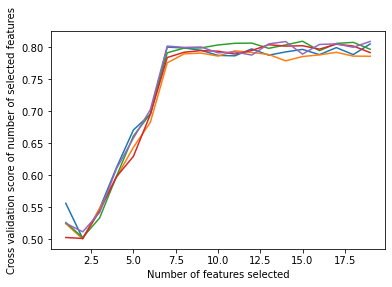

In [ ]:
# recursive feature elimination with cross validation and random forest classification
clf_rf = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='roc_auc')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature 0: 299.987174
Feature 1: 6.565937
Feature 2: 42.734394
Feature 3: 0.194172
Feature 4: 0.215337
Feature 5: 1.862194
Feature 6: 0.194172
Feature 7: 63.096284
Feature 8: 2816.671274
Feature 9: 14.545399
Feature 10: 1306.392588
Feature 11: 2003.816751
Feature 12: 1271.582777
Feature 13: 727.295008
Feature 14: 372.250447
Feature 15: 666.166229
Feature 16: 185.516640
Feature 17: 220.235284
Feature 18: 65.512322


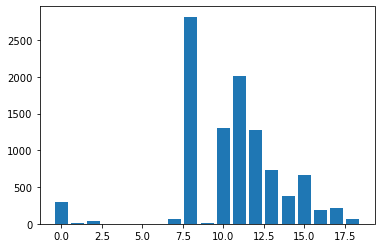

In [ ]:
# ANOVA FEATURE SELECTION
# What features influence the model the most

def anova_select_features(X_train, y_train, X_test):
    # configure to select all features
    afs = SelectKBest(score_func=f_classif, k='all')

    # learn relationship from training data
    afs.fit(X_train, y_train)

    # transform train and test input data
    X_train_fs = afs.transform(X_train)
    X_test_fs = afs.transform(X_test)

    return X_train_fs, X_test_fs, afs

# feature selection
X_train_fs, X_test_fs, afs = anova_select_features(X_train, y_train, X_test)

# get scores for the features
for i in range(len(afs.scores_)):
    print('Feature %d: %f' % (i, afs.scores_[i]))

plt.bar([i for i in range(len(afs.scores_))], afs.scores_)
plt.show()

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

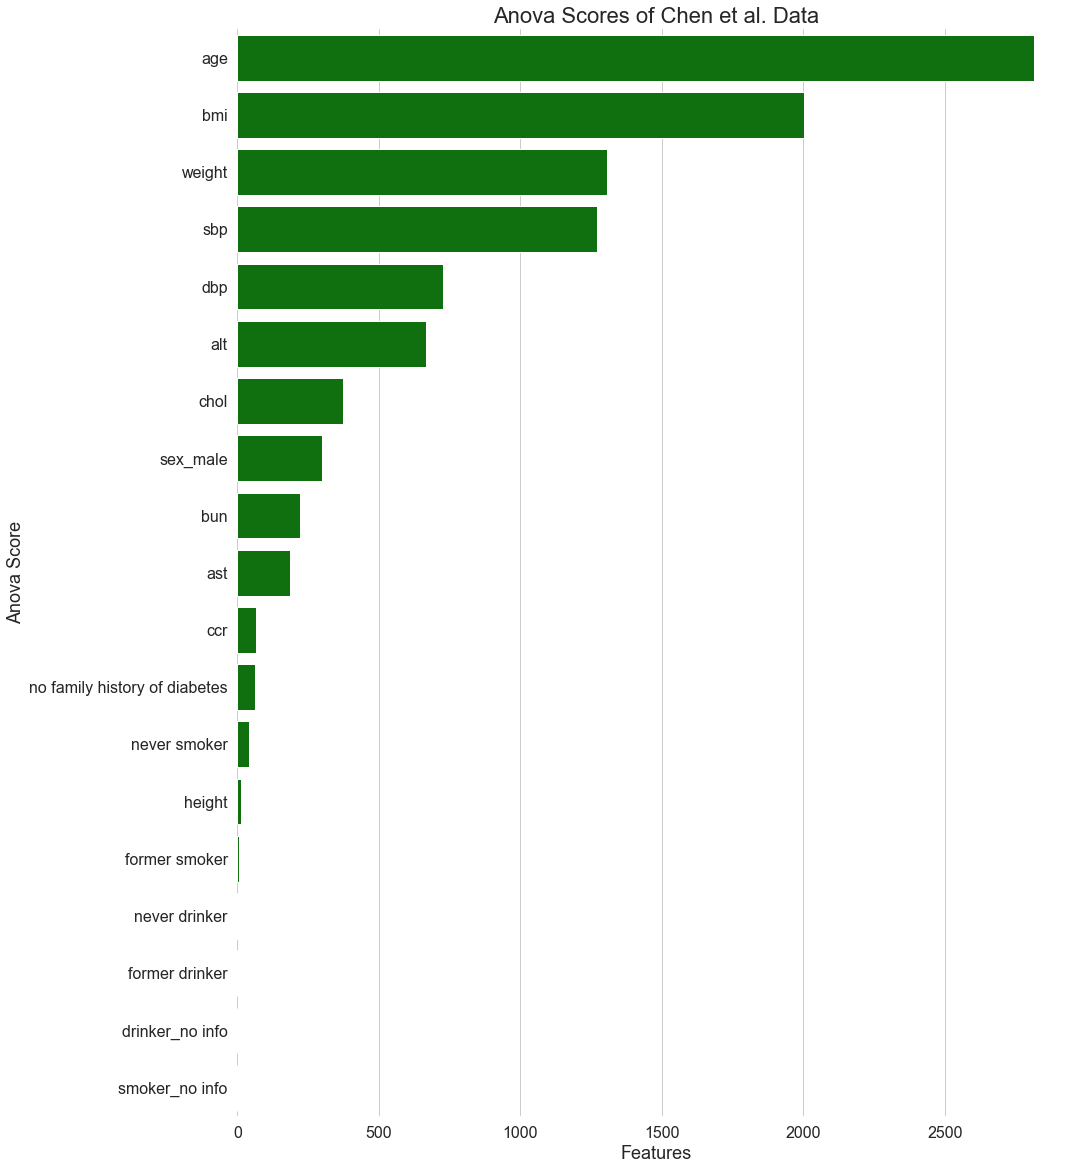

In [ ]:
# convert numpy array to df and bargraph
index_values = ['sex_male', 'former smoker', 'never smoker',
       'smoker_no info', 'former drinker', 'never drinker',
       'drinker_no info', 'no family history of diabetes', 'age',
       'height', 'weight', 'bmi', 'sbp', 'dbp', 'chol', 'alt', 'ast', 'bun',
       'ccr']

feature_data = {'Feature': index_values,
              'Anova_Score': afs.scores_}

featureDF = pd.DataFrame(feature_data)

sorted_features = featureDF.sort_values(by='Anova_Score', ascending=False)

# create bargraph with acending scores
sns.set_theme(style="whitegrid")
plt.figure(figsize = (15,20))
ax = sns.barplot(x='Anova_Score', 
                 y='Feature', 
                 data=sorted_features, 
                 color='green'
                )
ax.set_title('Anova Scores of Chen et al. Data', size=22)
ax.set_xlabel('Features', size=18)
ax.set_ylabel('Anova Score', size=18)
sns.despine(left=True, bottom=True)
plt.yticks(size = 16)
plt.xticks(size = 16)


In [27]:
## Linear SVC Baseline
# Train model linear SVC model 
lsvc = LinearSVC(class_weight='balanced',max_iter=10000).fit(X_train, y_train)

c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          no       1.00      0.74      0.85     66103
         yes       0.06      0.81      0.10      1272

    accuracy                           0.74     67375
   macro avg       0.53      0.77      0.48     67375
weighted avg       0.98      0.74      0.83     67375



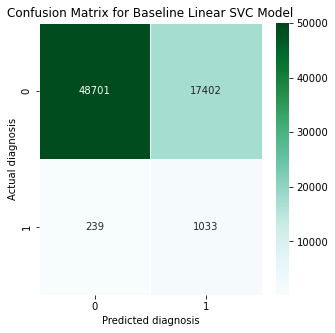

In [28]:
# Predict on test
pred_y_lsvc = lsvc.predict(X_test)

print(classification_report(y_test, pred_y_lsvc))

# Confusion matrix for LinearSVC model
lsvc_cm = confusion_matrix(y_test, pred_y_lsvc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(lsvc_cm, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Baseline Linear SVC Model')
plt.show()

              precision    recall  f1-score   support

          no       1.00      0.72      0.84     66103
         yes       0.05      0.83      0.10      1272

    accuracy                           0.72     67375
   macro avg       0.52      0.77      0.47     67375
weighted avg       0.98      0.72      0.82     67375

0.8430671421205918


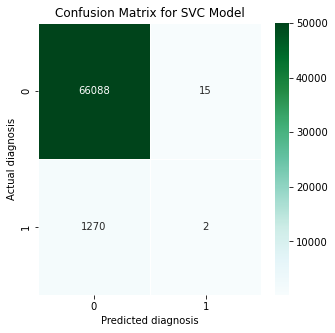

In [15]:
# standard SVC
# use class_weight='balanced' to penalize mistakes
# use probability=True to enable probability estimates

# Train SVC model
model_svc = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True).fit(X_train, y_train)


              precision    recall  f1-score   support

          no       1.00      0.72      0.84     66103
         yes       0.05      0.83      0.10      1272

    accuracy                           0.72     67375
   macro avg       0.52      0.77      0.47     67375
weighted avg       0.98      0.72      0.82     67375

0.8430671421205918


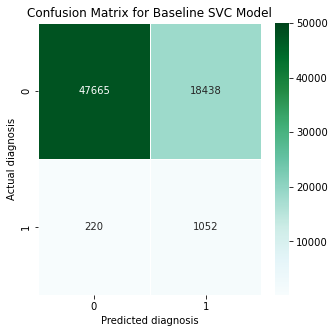

In [29]:
# Predict on training set
pred_y_svc = model_svc.predict(X_test)

print(classification_report(y_test, pred_y_svc))
prob_y_3 = model_svc.predict_proba(X_test)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

# Confusion matrix for LinearSVC model
svc_cm = confusion_matrix(y_test, pred_y_svc)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(svc_cm, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Baseline SVC Model')
plt.show()

#### **Part 2:** Models using selected features only

In [36]:
# only keep best predictive features for linear svf; helps with time and overfitting

df = data[['age','bmi','weight','sbp','dbp','alt','chol','diabetes']]

# retrieve array
dataset = df.values

# split into input and output
X = dataset[:, :-1]
y = dataset[:,-1]

# split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=data['diabetes'],random_state=1)

# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (136789, 7) (136789,)
Test (67375, 7) (67375,)


              precision    recall  f1-score   support

          no       0.98      1.00      0.99     66103
         yes       0.00      0.00      0.00      1272

    accuracy                           0.98     67375
   macro avg       0.49      0.50      0.50     67375
weighted avg       0.96      0.98      0.97     67375

0.8352216694986297


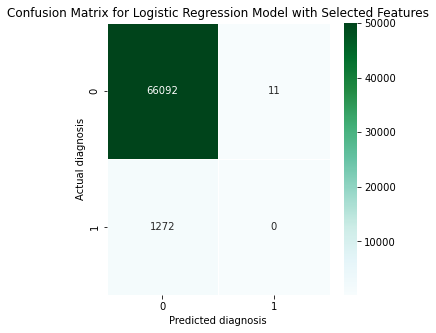

In [37]:
# logistic regression with selected features only

# Baseline Logistic Regression
lr_sf = LogisticRegression().fit(X_train, y_train)
 
# Predict on training set
pred_y_lr = lr_sf.predict(X_test)
print(classification_report(y_test, pred_y_lr))

prob_y_0 = lr_sf.predict_proba(X_test)
prob_y_0 = [p[1] for p in prob_y_0]
print(roc_auc_score(y_test, prob_y_0))

# Create a confusion matrix
prediction_lr = lr_sf.predict(X_test)
cm_lr = confusion_matrix(y_test, prediction_lr)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Logistic Regression Model with Selected Features')
plt.show()

c:\Users\Samantha Wainright\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          no       0.99      0.73      0.84     66103
         yes       0.06      0.81      0.10      1272

    accuracy                           0.74     67375
   macro avg       0.52      0.77      0.47     67375
weighted avg       0.98      0.74      0.83     67375



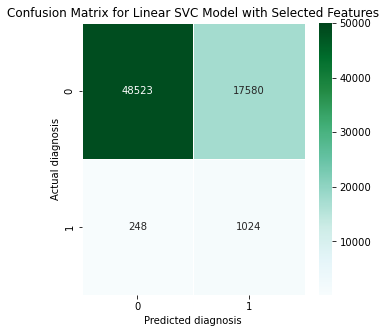

In [38]:
# linear SVC with selected features only
# Train model linear SVC model 
lsvc_sf = LinearSVC(class_weight='balanced',max_iter=10000).fit(X_train, y_train)

# Predict on test
pred_y_lsvc_sf = lsvc_sf.predict(X_test)
print(classification_report(y_test, pred_y_lsvc_sf))

# Confusion matrix for LinearSVC model
lsvc_cm_sf = confusion_matrix(y_test, pred_y_lsvc_sf)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(lsvc_cm_sf, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for Linear SVC Model with Selected Features')
plt.show()

# run 4m 24.4 sec

In [ ]:
# SVC with selected features only

# Train SVC model
model_svc_sf = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True).fit(X_train, y_train)

# run 91m 28.4s

              precision    recall  f1-score   support

          no       1.00      0.72      0.83     66103
         yes       0.05      0.83      0.10      1272

    accuracy                           0.72     67375
   macro avg       0.52      0.77      0.47     67375
weighted avg       0.98      0.72      0.82     67375

0.8374173864077379


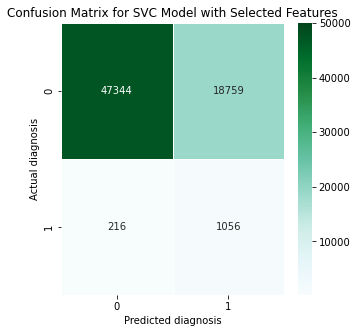

In [39]:
# Predict on training set
pred_y_svc_sf = model_svc_sf.predict(X_test)

print(classification_report(y_test, pred_y_svc_sf))
prob_y_3 = model_svc_sf.predict_proba(X_test)
prob_y_3 = [p[1] for p in prob_y_3]
print(roc_auc_score(y_test, prob_y_3))

# Confusion matrix for LinearSVC model
svc_cm_1 = confusion_matrix(y_test, pred_y_svc_sf)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(svc_cm_1, 
            annot = True, 
            linewidths=0.5, 
            fmt = ".0f", 
            ax=ax, 
            vmin=200,
            vmax=50000,
            cmap="BuGn")
ax.set_xlabel("Predicted diagnosis")
ax.set_ylabel("Actual diagnosis")
ax.set_title(f'Confusion Matrix for SVC Model with Selected Features')
plt.show()

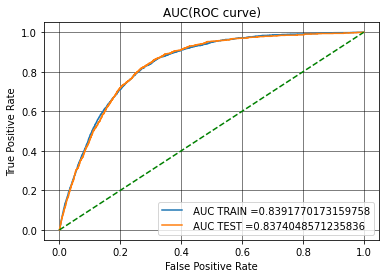

In [40]:
y_train_pred = model_svc_sf.decision_function(X_train)    
y_test_pred = model_svc_sf.decision_function(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred, pos_label='yes')
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred, pos_label='yes')

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()